In [1]:
from typing import Union
from urllib.parse import unquote, quote
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import inchi
from rdkit.Chem.MolStandardize import rdMolStandardize
import pickle
from mordred import Calculator, descriptors
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors as Descriptors
import os
from rdkit import Chem
from rdkit import RDPaths
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw import MolDraw2DSVG

from bokeh.plotting import ColumnDataSource, figure, output_file, show
from sklearn.decomposition import PCA
from bokeh.io import output_notebook

from molvs import standardize_smiles
import pandas as pd
from rdkit.Chem import inchi
from rdkit import Chem

import shap
shap.initjs()

from rdkit.Chem import AddHs
from rdkit.Chem import inchi
from IPython.display import display
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.MolStandardize import Standardizer
from rdkit.Chem import MolStandardize
from collections import Counter

import subprocess

from pandarallel import pandarallel
# Initialize pandarallel
pandarallel.initialize(progress_bar=True)

import warnings

# To ignore all warnings (not recommended for development, but can be useful in production)
warnings.filterwarnings("ignore")

import logging
from rdkit import RDLogger

# Suppress RDKit warnings and informational messages
RDLogger.DisableLog('rdApp.*')


def standardized_smiles(smiles):
    standardizer = Standardizer()
    smiles_original = smiles

    # Read SMILES and convert it to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)
 
    try:
        smiles_clean_counter = Counter()
        mol_dict = {}
        is_finalize = False

        for _ in range(5):
            
            #This solved phosphate oxidation in most cases but introduces a problem for some compounds: eg. geldanamycin where the stable strcutre is returned
            inchi_standardised = Chem.MolToInchi(mol)
            mol = Chem.MolFromInchi(inchi_standardised)
            
            # removeHs, disconnect metal atoms, normalize the molecule, reionize the molecule
            mol = rdMolStandardize.Cleanup(mol) 
            # if many fragments, get the "parent" (the actual mol we are interested in) 
            mol = rdMolStandardize.FragmentParent(mol)
            # try to neutralize molecule
            uncharger = rdMolStandardize.Uncharger() # annoying, but necessary as no convenience method exists
            
            mol = uncharger.uncharge(mol)# standardize molecules using MolVS and RDKit
            mol = standardizer.charge_parent(mol)
            mol = standardizer.isotope_parent(mol)
            mol = standardizer.stereo_parent(mol)
            
            #Normalize tautomers 
            #Method 1
            normalizer = MolStandardize.tautomer.TautomerCanonicalizer()
            mol = normalizer.canonicalize(mol)
            
            #Method 2
            te = rdMolStandardize.TautomerEnumerator() # idem
            mol = te.Canonicalize(mol)
            
            #Method 3
            mol = standardizer.tautomer_parent(mol)
       
    
            #Final Rules
            mol = standardizer.standardize(mol)
            mol_standardized = mol

            # convert mol object back to SMILES
            smiles_standardized = Chem.MolToSmiles(mol_standardized)

            if smiles == smiles_standardized:
                is_finalize = True
                break

            smiles_clean_counter[smiles_standardized] += 1
            if smiles_standardized not in mol_dict:
                mol_dict[smiles_standardized] = mol_standardized

            smiles = smiles_standardized
            mol = Chem.MolFromSmiles(smiles)

        if not is_finalize:
            # If the standardization process is not finalized, we choose the most common SMILES from the counter
            smiles_standardized = smiles_clean_counter.most_common()[0][0]
            # ... and the corresponding mol object
            #mol_standardized = mol_dict[smiles_standardized]
                
        return smiles_standardized 
    
    except:     
        
        return "Cannot_do"    
    
from dimorphite_dl.dimorphite_dl import DimorphiteDL

def protonate_smiles(smiles):

    dimorphite = DimorphiteDL(min_ph=7.0, max_ph=7.0, pka_precision=0)
    protonated_smiles = dimorphite.protonate(smiles)

    #print("protonated_smiles")

    if len(protonated_smiles) > 0:
                protonated_smiles = protonated_smiles[0]
            
    return protonated_smiles
    
def smiles_to_inchikey(smiles):
 
    try:
        
        # Convert SMILES to a molecule object
        mol = Chem.MolFromSmiles(smiles)
        # Convert the molecule object to an InChI string
        inchi_string = Chem.MolToInchi(mol)
        # Convert the InChI string to an InChIKey
        inchi_key = Chem.inchi.InchiToInchiKey(inchi_string)
        
        return inchi_key
    
    except:     
        
        return "Cannot_do"    
    
def MorganFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMorganFingerprintAsBitVect(x,2,2048))


def MACCSKeysFingerprint(s):
    x = Chem.MolFromSmiles(s)
    return (AllChem.GetMACCSKeysFingerprint(x))

def get_num_charged_atoms_neg(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) <= 0:
            negative += 1
     
    return negative

def get_num_charged_atoms_pos(mol):
    mol_h = Chem.AddHs(mol)
    Chem.rdPartialCharges.ComputeGasteigerCharges(mol_h)
     
    positive = 0
    negative = 0
     
    for atom in mol_h.GetAtoms():
        if float(atom.GetProp('_GasteigerCharge')) >= 0:
            positive += 1
    return positive

def get_assembled_ring(mol):
    ring_info = mol.GetRingInfo()
    num_ring = ring_info.NumRings()
    ring_atoms = ring_info.AtomRings()
    num_assembled = 0
     
    for i in range(num_ring):
        for j in range(i+1, num_ring):
            x = set(ring_atoms[i])
            y = set(ring_atoms[j])
            if not x.intersection(y): # 2つの環が縮環でない場合に
                for x_id in x:
                    x_atom = mol.GetAtomWithIdx(x_id)
                    neighbors = [k.GetIdx() for k in x_atom.GetNeighbors()]
                    for x_n in neighbors:
                        if x_n in y: # 環同士を繋ぐ結合があるか否か
                            num_assembled += 1
     
    return num_assembled

def get_num_stereocenters(mol):
    return AllChem.CalcNumAtomStereoCenters(mol) + AllChem.CalcNumUnspecifiedAtomStereoCenters(mol)

def calc_descriptors(dataframe):
    mols = dataframe.smiles_r.apply(Chem.MolFromSmiles)
    #mols_fps=[AllChem.GetMorganFingerprintAsBitVect(x,2) for x in mols]
    descr = []
    for m in mols:
        descr.append([Descriptors.TPSA(m),
               Descriptors.NumRotatableBonds(m),
               AllChem.CalcNumRings(m),
               Descriptors.NumAromaticRings(m),
               Descriptors.NumHAcceptors(m),
               Descriptors.NumHDonors(m),
               Descriptors.FractionCSP3(m),
               Descriptors.MolLogP(m) ,
               Descriptors.NHOHCount(m),
               Descriptors.NOCount(m),
               Descriptors.NumHeteroatoms(m),
               get_num_charged_atoms_pos(m),
               get_num_charged_atoms_neg(m),
               get_assembled_ring(m),
               get_num_stereocenters(m)])
    descr = np.asarray(descr)
    return(descr)

descs = [ 'PSA', 'n_rot_bonds', 'n_rings', 'n_ar_rings',
         'n_HBA', 'n_HBD', 'Fsp3', 'logP', 'NHOHCount', 'NOCount', 'NumHeteroatoms',
        'n_positive', '_n_negative', 'n_ring_asmbl', 'n_stereo']

def calc_all_fp_desc(data):
   
    calc = Calculator(descriptors, ignore_3D=True)
    print(len(calc.descriptors))
    Ser_Mol = data['smiles_r'].apply(Chem.MolFromSmiles)
    # as pandas
    Mordred_table=  calc.pandas(Ser_Mol)
    Mordred_table = Mordred_table.astype('float')
    #Mordred_table['smiles_r'] = model_tox_data['smiles_r']
    
    MACCSfingerprint_array = np.stack(data['smiles_r'].apply(MACCSKeysFingerprint))
    MACCS_collection = []
    for x in np.arange(MACCSfingerprint_array.shape[1]):
        x = "MACCS"+str(x)
        MACCS_collection.append(x)
    MACCSfingerprint_table = pd.DataFrame(MACCSfingerprint_array, columns=MACCS_collection)


    MorganFingerprint_array = np.stack(data['smiles_r'].apply(MorganFingerprint))
    Morgan_fingerprint_collection = []
    for x in np.arange(MorganFingerprint_array.shape[1]):
        x = "Mfp"+str(x)
        Morgan_fingerprint_collection.append(x)
    Morgan_fingerprint_table = pd.DataFrame(MorganFingerprint_array, columns=Morgan_fingerprint_collection)

    
    a=calc_descriptors(data)
    descdf=pd.DataFrame(a, columns=descs)
    descdf_approved=descdf.reset_index(drop=True)
    descdf_approved
    
    tox_model_data= pd.concat([data, Morgan_fingerprint_table, MACCSfingerprint_table, descdf_approved, Mordred_table], axis=1)
    tox_model_data
    
    return(tox_model_data)
    
    
liv_data = [ "3",  "5",  "6",  "7",  "8",  "11", "14", "15", "16"]

def predict_individual_liv_data(data_dummy, features, endpoint):#predict animal data
    
    loaded_rf = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))
    X = data_dummy[features]
    X = X.values
    y_proba =  loaded_rf.predict_proba(X)[:,1]  
    
    return(y_proba)

def predict_individual_cmax_data(data_dummy, features, endpoint):#predict animal data
    
    regressor = pickle.load(open(f"bestlivmodel_{endpoint}_model.sav", 'rb'))

    X = data_dummy[features]
    X = X.values
    #Add predictions to held out test set dili
    y_pred = regressor.predict(X)
    
    return(y_pred)

def predict_liv_all(data):
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    data_dummy = data

    for endpoint in liv_data:
        #print(endpoint)
        y_proba = predict_individual_liv_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
        
    for endpoint in ["median pMolar unbound plasma concentration" ,
               "median pMolar total plasma concentration"]:
        y_proba = predict_individual_cmax_data(data_dummy, features, endpoint) 
        data[endpoint] = y_proba
    
    return(data)


def predict_DILI(data):#log human_VDss_L_kg model
    
    #Read columns needed for rat data
    file = open(f"./features_morgan_mordred_maccs_physc.txt", "r")
    file_lines = file.read()
    features = file_lines.split("\n")
    features = features[:-1]
    
    features = list(features) + ["median pMolar unbound plasma concentration", "median pMolar total plasma concentration"] + list(liv_data) 
    loaded_rf = pickle.load(open("./final_dili_model.sav", 'rb'))
    #Note this mode was trained on all data before releasing (not just ncv data)

    X = data[features]
    y_proba =  loaded_rf.predict_proba(X)[:,1]
    best_thresh = 0.612911
    print('Best Threshold=%f' % (best_thresh))
    
    y_pred  = [ 1 if y_proba>best_thresh  else 0] 
    
    explainer = shap.TreeExplainer(loaded_rf)
    shap_values = explainer.shap_values(X)
    

    shap.force_plot(explainer.expected_value[1], 
    shap_values[1], X.iloc[0],
    matplotlib=True)
    
    
    flat_shaplist = [item for sublist in shap_values[1] for item in sublist]
    
    interpret = pd.DataFrame()
    interpret["name"] = features
    interpret["SHAP"] = flat_shaplist#print(flat_shaplist)
    plt.show()
    # Explaining the 4th instance

    return(interpret, y_proba, y_pred)


def mol2svg(mol):
    d2d = rdMolDraw2D.MolDraw2DSVG(200, 100)
    d2d.DrawMolecule(mol)
    d2d.FinishDrawing()
    return d2d.GetDrawingText()

source = ["Human hepatotoxicity",
"Animal hepatotoxicity A",
"Animal hepatotoxicity B",
"Preclinical hepatotoxicity",
"Diverse DILI A",
"Diverse DILI C",
"BESP",
"Mitotox",
"Reactive Metabolite"]


assaytype = ["Human hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Animal hepatotoxicity",
"Heterogenous Data ",
"Heterogenous Data ",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity",
"Mechanisms of Liver Toxicity"]


info = pd.DataFrame({"name": liv_data, "source": source, "assaytype": assaytype})
info

INFO: Pandarallel will run on 56 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


name                      source                     assaytype
0    3        Human hepatotoxicity          Human hepatotoxicity
1    5     Animal hepatotoxicity A         Animal hepatotoxicity
2    6     Animal hepatotoxicity B         Animal hepatotoxicity
3    7  Preclinical hepatotoxicity         Animal hepatotoxicity
4    8              Diverse DILI A            Heterogenous Data 
5   11              Diverse DILI C            Heterogenous Data 
6   14                        BESP  Mechanisms of Liver Toxicity
7   15                     Mitotox  Mechanisms of Liver Toxicity
8   16         Reactive Metabolite  Mechanisms of Liver Toxicity

In [ ]:
from dimorphite_dl.dimorphite_dl import DimorphiteDL

In [10]:
pip show dimorphite_dl

Name: dimorphite-dl
Version: 1.3.2
Summary: UNKNOWN
Home-page: https://www.github.com/Sulstice/dimorphite_dl
Author: Suliman Sharif
Author-email: sharifsuliman1@gmail.com
License: Apache 2.0
Location: /home/ss2686/miniconda3/envs/my-rdkit-env/lib/python3.9/site-packages
Requires: rdkit-pypi
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Add your SMILES representation here
smiles_list = ["CCCCOCCO"]

1613


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  6.66it/s]


Best Threshold=0.612911


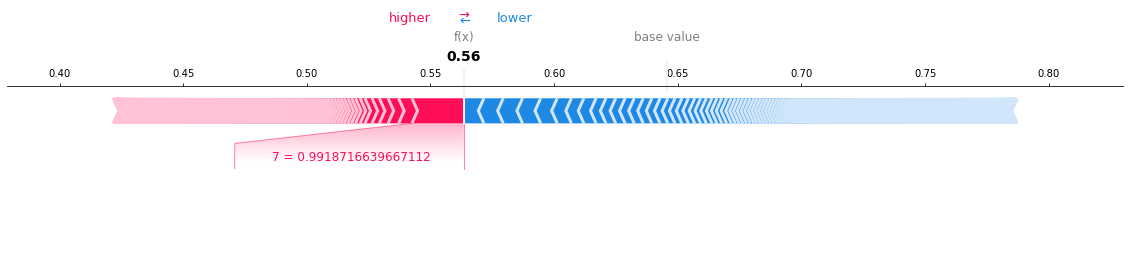

0.5634975562183783
0
The compound is predicted DILI-Negative
unbound Cmax:  7.35 uM
total Cmax:  12.78 uM
Most contributing MACCS substructure to DILI toxicity
Presence of this substructure contributes 0.0005 to prediction
Most contributing MACCS substructure to DILI safety
Presence of this substructure contributes -0.0012 to prediction


In [3]:
    for s in smiles_list:
        smiles = unquote(s)
    
        smiles_r = standardized_smiles(smiles)
        test = {'smiles_r':  [smiles_r]
                    }
        test = pd.DataFrame(test)

        desc=pd.read_csv("all_features_desc.csv", encoding='windows-1252')


        molecule = Chem.MolFromSmiles(smiles_r)     
        #st.image(Draw.MolToImage(molecule), width=200)
                
        test_mfp_Mordred = calc_all_fp_desc(test)
        test_mfp_Mordred_liv = predict_liv_all(test_mfp_Mordred)
        test_mfp_Mordred_liv_values = test_mfp_Mordred_liv.T.reset_index().rename(columns={"index":"name", 0: "value"})

        interpret, y_proba, y_pred = predict_DILI(test_mfp_Mordred_liv)   
        interpret = pd.merge(interpret, desc, right_on="name", left_on="name", how="outer")
        interpret = pd.merge(interpret, test_mfp_Mordred_liv_values, right_on="name", left_on="name", how="inner") 

        print(y_proba[0])
        print(y_pred[0]) 
        
        if(y_pred[0]==1):
            print("The compound is predicted DILI-Positive")
        if(y_pred[0]==0):
            print("The compound is predicted DILI-Negative")
        
        print("unbound Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar unbound plasma concentration"][0] *10**6, 2), "uM")
        print("total Cmax: ", np.round(10**-test_mfp_Mordred_liv["median pMolar total plasma concentration"][0] *10**6, 2), "uM")
        print("Most contributing MACCS substructure to DILI toxicity")
        
        top = interpret[interpret["SHAP"]>0].sort_values(by=["SHAP"], ascending=False)
        proxy_DILI_SHAP_top = pd.merge(info, top[top["name"].isin(liv_data)])
        proxy_DILI_SHAP_top["pred"] = proxy_DILI_SHAP_top["value"]>0.50
        proxy_DILI_SHAP_top["SHAP contribution to Toxicity"] = "Positive"
        proxy_DILI_SHAP_top["smiles"] = smiles_r
        
        top_positives = top[top["value"]==1]
        top_MACCS= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        top_MACCS_value= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        top_MACCS_shap= top_positives[top_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0] 
        top_MACCSsubstructure = Chem.MolFromSmarts(top_MACCS)
        
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(top_MACCSsubstructure), width=400)        
        print("Presence of this substructure contributes", np.round(top_MACCS_shap, 4), "to prediction")
                     
                 
        print("Most contributing MACCS substructure to DILI safety")
        bottom = interpret[interpret["SHAP"]<0].sort_values(by=["SHAP"], ascending=True)
        proxy_DILI_SHAP_bottom = pd.merge(info, bottom[bottom["name"].isin(liv_data)])
        proxy_DILI_SHAP_bottom["pred"] = proxy_DILI_SHAP_bottom["value"]>0.50
        proxy_DILI_SHAP_bottom["SHAP contribution to Toxicity"] = "Negative"
        proxy_DILI_SHAP_bottom["smiles"] = smiles_r
        
        bottom_positives = bottom[bottom["value"]==1]
        bottom_MACCS= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["description"].values[0]
        bottom_MACCS_value= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["value"].values[0]
        bottom_MACCS_shap= bottom_positives[bottom_positives.name.isin(desc.name.to_list()[-166:])].iloc[:1, :]["SHAP"].values[0]     
        bottom_MACCSsubstructure = Chem.MolFromSmarts(bottom_MACCS)
                 
                                  
        Draw.MolToImage(molecule, highlightAtoms=molecule.GetSubstructMatch(bottom_MACCSsubstructure), width=400) 
        print("Presence of this substructure contributes", np.round(bottom_MACCS_shap, 4), "to prediction")

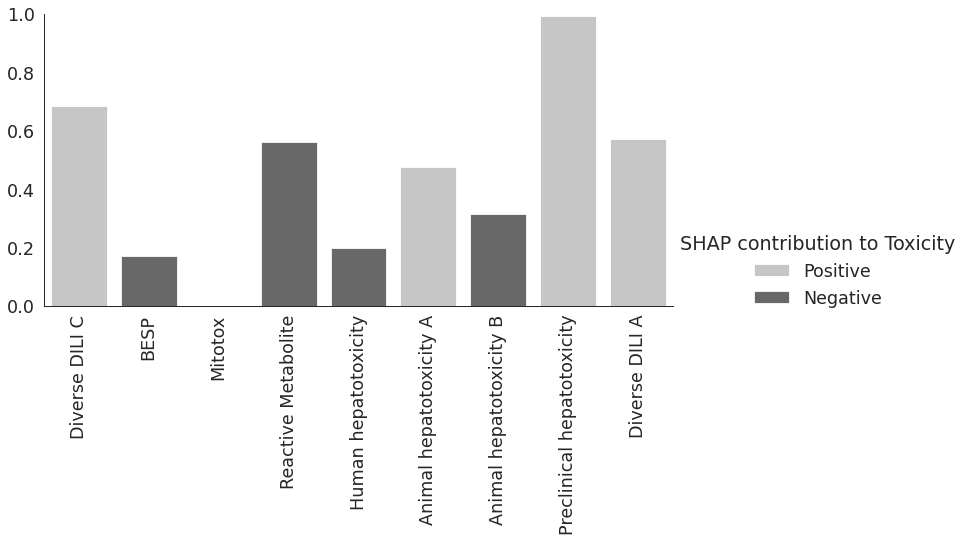

In [4]:
import seaborn as sns
SHAP =pd.DataFrame(columns=['name', 'source', 'assaytype', 'SHAP', 'description', 'value', 'pred','influence', 'smiles'])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_top])
SHAP = pd.concat([SHAP, proxy_DILI_SHAP_bottom])
SHAP["name"] = SHAP["name"].astype(str)
SHAP = SHAP.sort_values(by=["name"], ascending=True)
#fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.set_style('white')
sns.set_context('paper', font_scale=2)
hue_order = ['Positive', 'Negative']
#sns.barplot(data=compound, x="source", y="value", color='grey')
g = sns.catplot(data=SHAP, x="source", y="value", kind="bar", hue_order=hue_order,  hue="SHAP contribution to Toxicity",  
                palette="Greys", height=5, aspect=2, dodge=False, legend=True)
#plt.axhline(y=0.5, color='r', linestyle='--')
g.set_xticklabels(rotation=90)
g.set(ylabel=None)
g.set(xlabel=None)
g.set(ylim=(0, 1))
plt.show()

In [5]:
SHAP

name                      source                     assaytype      SHAP  \
3   11              Diverse DILI C            Heterogenous Data   0.004235   
2   14                        BESP  Mechanisms of Liver Toxicity -0.000216   
3   15                     Mitotox  Mechanisms of Liver Toxicity -0.008084   
4   16         Reactive Metabolite  Mechanisms of Liver Toxicity -0.000719   
0    3        Human hepatotoxicity          Human hepatotoxicity -0.006702   
0    5     Animal hepatotoxicity A         Animal hepatotoxicity  0.002946   
1    6     Animal hepatotoxicity B         Animal hepatotoxicity -0.001956   
1    7  Preclinical hepatotoxicity         Animal hepatotoxicity  0.020985   
2    8              Diverse DILI A            Heterogenous Data   0.005413   

                                         description     value   pred  \
3  Transient liver function abnormalities, advers...  0.683299   True   
2              BESP Bile Salt Export Pump Inhibition  0.172278  False   
3                                           Mitotox    0.00126  False   
4                      Reactive Metabolite Formation  0.561835   True   
0                Human hepatotoxicity, hepatobiallry  0.199695  False   
0  Rat, chronic oral administration, Hepatic hist...  0.474123  False   
1       Hepatocellular hypertrophy, rats, ORAD, HESS  0.313287  False   
1  Preclinical hepatotoxicity data from PharmaPen...  0.991872   True   
2  Large-scale and diverse ddrug induced liver in...  0.571555   True   

  influence    smiles SHAP contribution to Toxicity  
3       NaN  CCCCOCCO                      Positive  
2       NaN  CCCCOCCO                      Negative  
3       NaN  CCCCOCCO                      Negative  
4       NaN  CCCCOCCO                      Negative  
0       NaN  CCCCOCCO                      Negative  
0       NaN  CCCCOCCO                      Positive  
1       NaN  CCCCOCCO                      Negative  
1       NaN  CCCCOCCO                      Positive  
2       NaN  CCCCOCCO                      Positive

In [6]:
compound = SHAP[SHAP["smiles"]==smiles].sort_values(by=["name"], ascending=True)
pos= compound[compound["SHAP"]>0].sort_values(by="SHAP", ascending=False)
neg = compound[compound["SHAP"]<0].sort_values(by="SHAP", ascending=True)
    
print(pos["source"][:3])
print(neg["source"][:3])
    
  

1    Preclinical hepatotoxicity
2                Diverse DILI A
3                Diverse DILI C
Name: source, dtype: object
3                    Mitotox
0       Human hepatotoxicity
1    Animal hepatotoxicity B
Name: source, dtype: object


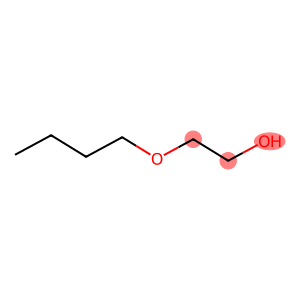

In [7]:
m = Chem.MolFromSmiles(smiles)
Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(bottom_MACCSsubstructure), width=200)  

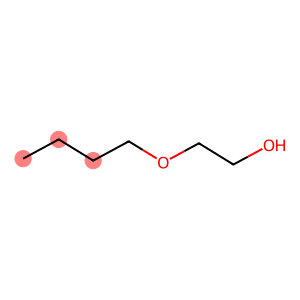

In [8]:
m = Chem.MolFromSmiles(smiles)
Draw.MolToImage(m, highlightAtoms=m.GetSubstructMatch(top_MACCSsubstructure), width=200)  